# Section 22:  Training Non-Linear Classifiers with Decision Tree Techniques

## Automated Learning of Logical Rules

A lightbulb hangs above a stairwell. The bulb is connected to two switches. When both switches turned are off, the bulb stays off. If either switch is turned on, then the bulb will shine. However, if both switches are flipped on, then the bulb will turn off. Using the material from the previous two sections, can we train a classifier to learn this relationship? We'll find out by visualizing the problem in 2D space.

**Listing 22. 1. Plotting the two-switch problem in 2D space**

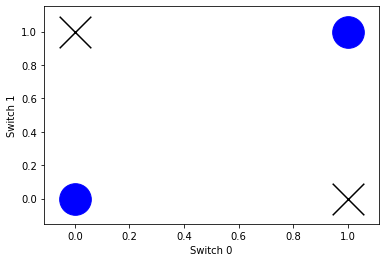

In [1]:
import numpy as np
import matplotlib.pyplot as plt
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y = (X[:,0] + X[:,1] == 1).astype(int)

for i in [0, 1]:
    plt.scatter(X[y == i][:,0], X[y == i][:,1], 
                marker=['o', 'x'][i], color=['b', 'k'][i],
                s=1000)
plt.xlabel('Switch 0')
plt.ylabel('Switch 1')
plt.show()

KNN will fail to properly classify the data. Furthermore, there does not exist a linear separation between the labeled classes. We cannot draw a linear boundary without cutting through a diagonal that connects two identically classified points. Consequently, training a linear classifier is also out of the question. What should we do? One approach is to define two nested if/else statements as our prediction model.

**Listing 22. 2. Classifying data using nested if/else statements**

In [2]:
def classify(features):
    switch0, switch1 = features
    
    if switch0 == 0:
        if switch1 == 0:
            prediction = 0
        else:
            prediction = 1
    else:
        if switch1 == 0:
            prediction = 1
        else:
            prediction = 0
    
    return prediction

for i in range(X.shape[0]):
    assert classify(X[i]) == y[i]

We need to find a way to automatically derive accurate if / else statements from the training data.  We’ll start with a simple training example. Our training set will represent a series of recorded observations between a single light switch and a single bulb. Whenever the switch is on, the bulb is on, and vice-versa. 

**Listing 22. 3. Generating a single switch training set**

In [3]:
np.random.seed(0)
y_simple = np.random.binomial(1, 0.5, size=10)
X_simple = np.array([[e] for e in y_simple])
print(f"features: {X_simple}")
print(f"\nlabels: {y_simple}")

features: [[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]

labels: [1 1 1 1 0 1 0 1 1 0]


Next, we'll count all observations in which the switch is off and the light is off.

**Listing 22. 4. Counting the off-state co-occurrences**

In [4]:
count = (X_simple[:,0][y_simple == 0] == 0).sum()
print(f"In {count} instances, both the switch and the light are off")

In 3 instances, both the switch and the light are off


Now, lets count the instances in which both the switch and light bulb are turned on.

**Listing 22. 5. Counting the on-state co-occurrences**

In [5]:
count = (X_simple[:,0][y_simple == 1] == 1).sum()
print(f"In {count} instances, both the switch and the light are on")

In 7 instances, both the switch and the light are on


These co-occurrences will prove useful during classifier training. Lets track the counts more systematically within a co-occurrence matrix `M`.

**Listing 22. 6. Computing a co-occurrence matrix**

In [6]:
def get_co_occurrence(X, y, col=0):
    co_occurrence = []
    for i in [0, 1]:
        counts = [(X[:,col][y == i] == j).sum()
                  for j in [0, 1]] 
        co_occurrence.append(counts)
    
    return np.array(co_occurrence)

M = get_co_occurrence(X_simple, y_simple)
assert M[0][0] == 3
assert M[1][1] == 7
print(M)

[[3 0]
 [0 7]]


Suppose that there's a flaw in the switch toggle. We flip the switch off, but the bulb stays on! Lets add this anomalous observation to our data, and subsequently recompute matrix `M`.

**Listing 22. 7. Adding a flawed mismatch to the data**

In [7]:
X_simple = np.vstack([X_simple, [1]])
y_simple = np.hstack([y_simple, [0]])
M = get_co_occurrence(X_simple, y_simple)
print(M)

[[3 1]
 [0 7]]


How accurately can we predict the state of the light-bulb if we know that the switch is off? In order to find out, we must divide `M[0]` by `M[0].sum()`. This will produce a probability distribution over possible light-bulb states whenever the switch-state is set to `0`.

**Listing 22. 8. Computing bulb probabilities when the switch is off**

In [8]:
bulb_probs = M[0] / M[0].sum()
print("When the switch is set to 0, the bulb state probabilities are:")
print(bulb_probs)

prob_on, prob_off = bulb_probs
print(f"\nThere is a {100 * prob_on:.0f}% chance that the bulb is off.")
print(f"There is a {100 * prob_off:.0f}% chance that the bulb is on.")

When the switch is set to 0, the bulb state probabilities are:
[0.75 0.25]

There is a 75% chance that the bulb is off.
There is a 25% chance that the bulb is on.


When the switch is off, we can predict the state of the bulb with 75% accuracy. Now lets optimize the accuracy for the scenario in which the switch is on. 

**Listing 22. 9. Predicting the state of the bulb when the switch is on**

In [9]:
bulb_probs = M[1] / M[1].sum()
print("When the switch is set to 1, the bulb state probabilities are:")
print(bulb_probs)

prediction = ['off', 'on'][bulb_probs.argmax()]
accuracy = bulb_probs.max()
print(f"\nWe assume the bulb is {prediction} with "
      f"{100 * accuracy:.0f}% accuracy")

When the switch is set to 1, the bulb state probabilities are:
[0. 1.]

We assume the bulb is on with 100% accuracy


How do we combine our two accuracy values into a single accuracy score? Naively, we could simply average 0.75 and 1.0. However, that approach would be erroneous. The two accuracies should not be weighted evenly, since the switch is on nearly twice as often as it is off.

**Listing 22. 10. Counting the on / off states of the switch**

In [10]:
for i, count in enumerate(M.sum(axis=1)):
    state = ['off', 'on'][i]
    print(f"The switch is {state} in {count} observations.")

The switch is off in 4 observations.
The switch is on in 7 observations.


The switch is on more frequently than it is off. Hence, to get a meaningful accuracy score, we need to take the weighted average of 0.75 and 1.0.

**Listing 22. 11. Computing total accuracy**

In [11]:
accuracies = [0.75, 1.0]
total_accuracy = np.average(accuracies, weights=M.sum(axis=1))
print(f"Our total accuracy is {100 * total_accuracy:.0f}%")

Our total accuracy is 91%


If the switch is off, we predict that the bulb is off. Otherwise, we predict that the bulb is on. This model is 91% accurate. Furthermore, the model can be represented as a simple if/else Python statement, which we can train from scratch.

**Listing 22. 12. Training a simple if/else model**

In [12]:
def train_if_else(X, y, feature_col=0, feature_name='feature'):
    M = get_co_occurrence(X, y, col=feature_col)
    probs0, probs1 = [M[i] / M[i].sum() for i in [0, 1]]
    
    if_else = f"""if {feature_name} == 0:
    prediction = {probs0.argmax()}
else:
    prediction = {probs1.argmax()}
    """.strip()

    if probs0.argmax() == probs1.argmax():
        if_else = f"prediction = {probs0.argmax()}"

    accuracies = [probs0.max(), probs1.max()]
    total_accuracy = np.average(accuracies, weights=M.sum(axis=1))
    return if_else, total_accuracy

if_else, accuracy = train_if_else(X_simple, y_simple, feature_name='switch')
print(if_else)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if switch == 0:
    prediction = 0
else:
    prediction = 1

This statement is 91% accurate.


We're able to train a simple if/else model using a single  feature. Now, we'll figure out how to train a nested if/else model using two features.

### Training a Nested If/Else Model Using Two Features

Lets return to our system of two light-switches connecting to a single staircase bulb. Our two features, `switch0` and `switch1`, correspond to columns `0` and `1` of matrix `X`. However, the `train_if_else` function can only train on one column at a time. Lets train two separate models and compare them.

**Listing 22. 13. Training models on the two-switch system**

In [13]:
feature_names = [f"switch{i}" for i in range(2)]
for i, name in enumerate(feature_names):
    _, accuracy = train_if_else(X, y, feature_col=i, feature_name=name)
    print(f"The model trained on {name} is {100 * accuracy:.0f}% "
           "accurate.")

The model trained on switch0 is 50% accurate.
The model trained on switch1 is 50% accurate.


 A single if/else statement is insufficient to capture the complexity of the problem. We must break the problem into parts by training two separate models; _A_ and _B_.  _Model A_ will consider only those scenarios in which `switch0` is set to off. We'll start by isolating a training subset that satisfies this boolean requirement.
 
 
**Listing 22. 14. Isolating a training subset where `switch0` is off**

In [14]:
is_off = X[:,0] == 0
X_switch0_off = X[is_off]
y_switch0_off = y[is_off]
print(f"Feature matrix when switch0 is off:\n{X_switch0_off}")
print(f"\nClass labels when switch0 is off:\n{y_switch0_off}")

Feature matrix when switch0 is off:
[[0 0]
 [0 1]]

Class labels when switch0 is off:
[0 1]


`X_switch0_off[:,0]` always equals zero. Thus this zero column is now redundant. Lets delete it.

**Listing 22. 15. Deleting a redundant feature column**

In [15]:
X_switch0_off = np.delete(X_switch0_off, 0, axis=1) 
print(X_switch0_off)

[[0]
 [1]]


Next, we'll train an if/else model on the training subset. 

**Listing 22. 16. Training a model when `switch0` is off**

In [16]:
results = train_if_else(X_switch0_off, y_switch0_off, 
                        feature_name='switch1')
switch0_off_model, off_accuracy = results
print("If switch 0 is off, then the following if/else model is "
      f"{100 * off_accuracy:.0f}% accurate.\n\n{switch0_off_model}")

If switch 0 is off, then the following if/else model is 100% accurate.

if switch1 == 0:
    prediction = 0
else:
    prediction = 1


Now, lets train a corresponding model to cover all the cases where `switch0` is on. We'll start by filtering our training data based on the condition `X[:,0] == 1`.

**Listing 22. 17. Isolating a training subset where `switch0` is on**

In [17]:
def filter_X_y(X, y, feature_col=0, condition=0):
    inclusion_criteria = X[:,feature_col] == condition
    y_filtered = y[inclusion_criteria]
    X_filtered = X[inclusion_criteria]
    X_filtered = np.delete(X_filtered, feature_col, axis=1)
    return X_filtered, y_filtered

X_switch0_on, y_switch0_on = filter_X_y(X, y, condition=1)

Next, we'll train `switch0_on_model` using the filtered training set.

**Listing 22. 18. Training a model when `switch0` is on**

In [18]:
results = train_if_else(X_switch0_on, y_switch0_on, 
                        feature_name='switch1')
switch0_on_model, on_accuracy = results
print("If switch 0 is on, then the following if/else model is "
      f"{100 * on_accuracy:.0f}% accurate.\n\n{switch0_on_model}")

If switch 0 is on, then the following if/else model is 100% accurate.

if switch1 == 0:
    prediction = 1
else:
    prediction = 0


Together, our two models can be easily combined into a single nested if/else statement.

**Listing 22. 19. Combining seperate if/else models together**

In [19]:
def combine_if_else(if_else_a, if_else_b, feature_name='feature'):
    return  f"""
if {feature_name} == 0:
{add_indent(if_else_a)}
else:
{add_indent(if_else_b)}
""".strip()

def add_indent(if_else):
    return '\n'.join([4 * ' ' + line for line in if_else.split('\n')])

nested_model = combine_if_else(switch0_off_model, switch0_on_model, 
                               feature_name='switch0')
print(nested_model)

if switch0 == 0:
    if switch1 == 0:
        prediction = 0
    else:
        prediction = 1
else:
    if switch1 == 0:
        prediction = 1
    else:
        prediction = 0


Our combined model is 100% accurate. We can confirm by taking the weighted average of `off_accuracy` and `on_accuracy`. 

**Listing 22. 20. Computing total nested accuracy**

We're able to generate a nested two-feature model in an automated manner. Our strategy hinges on the creation of separate training sets. That separation is determined by the on/off states of one the features. This type of separation is called a **binary split**.

**Listing 22. 21. Defining a binary split function**

In [20]:
def split(X, y, feature_col=0, condition=0):
    has_condition = X[:,feature_col] == condition
    X_a, y_a = [e[has_condition] for e in [X, y]] 
    X_b, y_b = [e[~has_condition] for e in [X, y]]
    X_a, X_b = [np.delete(e, feature_col, axis=1) for e in [X_a, X_b]]
    return [X_a, X_b, y_a, y_b]

X_a, X_b, y_a, y_b = split(X, y)
assert np.array_equal(X_a, X_switch0_off) 
assert np.array_equal(X_b, X_switch0_on)

Lets define a `train_nested_if_else` to systematically execute our two-feature training logic from the previous code listings.

**Listing 22. 22. Training a nested if/else model**

In [21]:
def train_nested_if_else(X, y, split_col=0, 
                         feature_names=['feature1', 'feature1']):
    split_name = feature_names[split_col]
    simple_model, simple_accuracy = train_if_else(X, y, split_col, 
                                                  split_name)
    if simple_accuracy == 1.0:
        return (simple_model, simple_accuracy)
    
    X_a, X_b, y_a, y_b = split(X, y, feature_col=split_col)
    in_name = feature_names[1 - split_col] 
    if_else_a, accuracy_a = train_if_else(X_a, y_a, feature_name=in_name) 
    if_else_b, accuracy_b = train_if_else(X_b, y_b, feature_name=in_name)
    nested_model = combine_if_else(if_else_a, if_else_b, split_name)
    accuracies = [accuracy_a, accuracy_b]
    nested_accuracy = np.average(accuracies, weights=[y_a.size, y_b.size])
    if nested_accuracy > simple_accuracy:
        return (nested_model, nested_accuracy)
    
    return (simple_model, simple_accuracy)

feature_names = ['switch0', 'switch1']
model, accuracy = train_nested_if_else(X, y, feature_names=feature_names)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if switch0 == 0:
    if switch1 == 0:
        prediction = 0
    else:
        prediction = 1
else:
    if switch1 == 0:
        prediction = 1
    else:
        prediction = 0

This statement is 100% accurate.


Our function trained a model that's 100% accurate. Given our current training set, that accuracy should hold even if we split on `switch1` instead of `switch0`.

**Listing 22. 23. Splitting on `switch1` instead of `switch0`**

In [22]:
model, accuracy = train_nested_if_else(X, y, split_col=1,
                                       feature_names=feature_names)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if switch1 == 0:
    if switch0 == 0:
        prediction = 0
    else:
        prediction = 1
else:
    if switch0 == 0:
        prediction = 1
    else:
        prediction = 0

This statement is 100% accurate.


Splitting on either feature will yield the same result. This is true of our two-switch system. However, this is not the case for many real-world training sets.

#### Deciding which Feature to Split On

Suppose we wish to train an if/else model that predicts whether or not it’s raining outside. The model returns `1` if it is raining and `0` otherwise. We'll simulate the relationship between features (seasons and wetness) and rain-observation using random sampling.

**Listing 22. 24. Simulating a rainy-day training set**

In [23]:
np.random.seed(1)
y_rain = np.random.binomial(1, 0.6, size=100) 
is_wet = [e if np.random.binomial(1, 0.95) else 1 - e for e in y_rain] 
is_fall = [e if np.random.binomial(1, 0.6) else 1 - e for e in y_rain]
X_rain = np.array([is_fall, is_wet]).T

Now, lets train a model by splitting on the _Autumn_ feature.

**Listing 22. 25. Training a model with an _Autumn_ split**

In [24]:
feature_names = ['is_autumn', 'is_wet']
model, accuracy = train_nested_if_else(X_rain, y_rain, 
                                       feature_names=feature_names)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if is_autumn == 0:
    if is_wet == 0:
        prediction = 0
    else:
        prediction = 1
else:
    if is_wet == 0:
        prediction = 0
    else:
        prediction = 1

This statement is 95% accurate.


We trained a nested model that is 95% accurate. What if we split on the _Wetness_ feature instead?

**Listing 22. 26. Training a model with a Wetness split**

Splitting on some features leads to more preferable results. How should we select the best feature for the split? 
One solution requires us to examine the distribution of classes within the training set. We'll do this by first printing the probability of rain.

**Listing 22. 27. Computing the probability of rain**

In [25]:
prob_rain = y_rain.sum() / y_rain.size
print(f"It rains in {100 * prob_rain:.0f}% of our observations.")

It rains in 61% of our observations.


It rains in 61% of total observations. How is that probability altered when we split on _Autumn_?

**Listing 22. 28. Computing the probability of rain based on the season**

In [26]:
y_fall_a, y_fall_b = split(X_rain, y_rain, feature_col=0)[-2:]
for i, y_fall in enumerate([y_fall_a, y_fall_b]):
    prob_rain = y_fall.sum() / y_fall.size
    state = ['not autumn', 'autumn'][i]
    print(f"It rains {100 * prob_rain:.0f}% of the time when it is "
          f"{state}")

It rains 55% of the time when it is not autumn
It rains 66% of the time when it is autumn


If we know that it is autumn, then we are slightly more confident in rain. Still, our confidence increase is not very substantial relative to the original training set. What if instead we were to split on _Wetness_ ? 

**Listing 22. 29. Computing the probability of rain based on wetness**

In [27]:
y_wet_a, y_wet_b = split(X_rain, y_rain, feature_col=1)[-2:]
for i, y_wet in enumerate([y_wet_a, y_wet_b]):
    prob_rain = y_wet.sum() / y_wet.size
    state = ['not wet', 'wet'][i]
    print(f"It rains {100 * prob_rain:.0f}% of the time when it is "
          f"{state}")

It rains 10% of the time when it is not wet
It rains 98% of the time when it is wet


The _Wetness_ split returns two class-label arrays whose corresponding rain probabilities are either very low or very high. These extreme probabilities are an indication of class imbalance.  When choosing between two splits, we should select the split that yields more imbalanced class-labels. Lets figure out how to quantify class imbalance. Generally, imbalance is associated with the shape of the class probability distribution. We can treat this distribution as a vector `v`, where `v[i]` equals probability of observing _Class i_. Lets visualize the distribution vectors associated with the _Autumn_ and _Wetness_ splits.

**Listing 22. 30. Plotting the class distribution vectors**

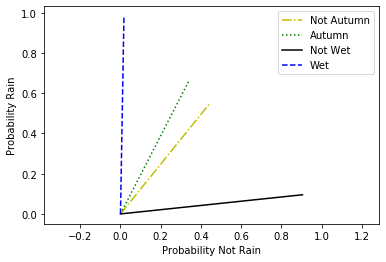

In [28]:
def get_class_distribution(y):
    prob_rain = y.sum() / y.size
    return np.array([1 - prob_rain, prob_rain])

def plot_vector(v, label, linestyle='-', color='b'):
    plt.plot([0, v[0]], [0, v[1]], label=label, 
             linestyle=linestyle, c=color)

classes = [y_fall_a, y_fall_b, y_wet_a, y_wet_b]
distributions = [get_class_distribution(y) for y in classes]
labels = ['Not Autumn', 'Autumn', 'Not Wet', 'Wet']
colors = ['y', 'g', 'k', 'b']
linestyles = ['-.', ':', '-', '--']
for tup in zip(distributions, labels, colors, linestyles):
    vector, label, color, linestyle = tup
    plot_vector(vector, label, linestyle=linestyle, color=color)

plt.legend()
plt.xlabel('Probability Not Rain')
plt.ylabel('Probability Rain')
plt.axis('equal')
plt.show()

The balanced _Autumn_ vectors are much shorter than the vectors associated with _Wetness_. This isn't a coincidence. Imbalanced distributions are proven to have greater vector magnitudes. Also, the magnitude is equal to the square-root of `v @ v`. Hence, the dot-product of a distribution vector with itself will be greater if that vector is more imbalanced! Lets demonstrate this property for every 2D vector `v = [1 - p, p]`.

**Listing 22. 31. Plotting the distribution vector magnitudes**

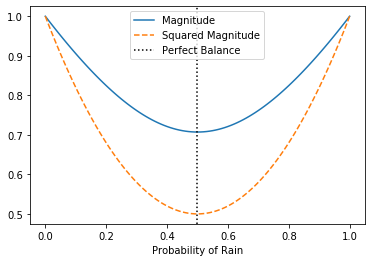

In [29]:
prob_rain = np.arange(0, 1.001, 0.01)
vectors = [np.array([1 - p, p]) for p in prob_rain]
magnitudes = [np.linalg.norm(v) for v in vectors] 
square_magnitudes = [v @ v for v in vectors]
plt.plot(prob_rain, magnitudes, label='Magnitude')
plt.plot(prob_rain, square_magnitudes, label='Squared Magnitude',
         linestyle='--')
plt.xlabel('Probability of Rain')
plt.axvline(0.5, color='k', label='Perfect Balance', linestyle=':')
plt.legend()
plt.show()

`v @ v` serves as an excellent metric for class-label imbalance. However, data scientists prefer the slightly different metric of `1 - v @ v`. This metric, called **Gini Impurity**, essentially flips the plotted curve.

**Listing 22. 32. Plotting the Gini Impurity**

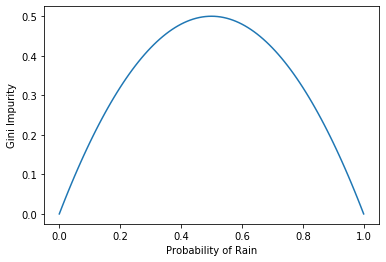

In [30]:
gini_impurities = [1 - (v @ v) for v in vectors]
plt.plot(prob_rain, gini_impurities)
plt.xlabel('Probability of Rain')
plt.ylabel('Gini Impurity')
plt.show()

Gini Impurity is a standard measure of class imbalance. Lets compute the impurities associated with _Autumn_ and _Wetness_. This will require us to compute weighted mean of impurities associated with each split.

**Listing 22. 33. Computing each feature’s Gini Impuritity**

In [31]:
def compute_impurity(y_a, y_b): 
    v_a = get_class_distribution(y_a)
    v_b = get_class_distribution(y_b) 
    impurities = [1 - v @ v for v in [v_a, v_b]] 
    weights = [y.size, y_b.size]
    return np.average(impurities, weights=weights) 

fall_impurity = compute_impurity(y_fall_a, y_fall_b)
wet_impurity = compute_impurity(y_wet_a, y_wet_b)
print(f"When we split on Autumn, the Impurity is {fall_impurity:0.2f}.")
print(f"When we split on Wetness, the Impurity is {wet_impurity:0.2f}.")

When we split on Autumn, the Impurity is 0.45.
When we split on Wetness, the Impurity is 0.04.


The Impurity is minimized when we split on _Wetness_. Going forward, we will split on features whose Gini Impurity is minimized.

**Listing 22. 34. Sorting features by Gini Impurity**

In [32]:
def sort_feature_indices(X, y):
    feature_indices = range(X.shape[1])
    impurities = []
    
    for i in feature_indices: 
        y_a, y_b = split(X, y, feature_col=i)[-2:]
        impurities.append(compute_impurity(y_a, y_b))
    
    return sorted(feature_indices, key=lambda i: impurities[i]) 

indices = sort_feature_indices(X_rain, y_rain)
top_feature = feature_names[indices[0]]
print(f"The feature with the minimal impurity is: '{top_feature}'")

The feature with the minimal impurity is: 'is_wet'


The `sorted_feature_indices` function will prove invaluable as we train nested if/else models with more than two features.

### Training If/Else Models with More Than Two Features

We’ll now train a more complicated model that will predict whether or not it will rain tomorrow. 

The model will rely on on the following three features:

1. Has it rained at any point today?

2. Is today a cloudy day?

3. Is today an autumn day? 

Below, we'll simulate a training set `(X_rain, y_rain)` based on the probabilistic relationships between the features. 

**Listing 22. 35. Simulating a three-feature training set**

In [33]:
np.random.seed(0)
def simulate_weather():
    is_fall = np.random.binomial(1, 0.25)
    is_cloudy = np.random.binomial(1, [0.3, 0.7][is_fall])
    rained_today = np.random.binomial(1, [0.05, 0.4][is_cloudy])
    if rained_today:
        rains_tomorrow = np.random.binomial(1, 0.5)
    else:
        rains_tomorrow = np.random.binomial(1, [0.05, 0.15][is_fall])
    
    features = [rained_today, is_cloudy, is_fall]
    return features, rains_tomorrow

X_rain, y_rain = [], []
for _ in range(1000):
    features, rains_tomorrow = simulate_weather()
    X_rain.append(features)
    y_rain.append(rains_tomorrow)
    
X_rain, y_rain = np.array(X_rain), np.array(y_rain)

The columns in `X_rain` correspond to features `'is_fall'`, `'is_cloudy'`, and `'rained_today'`. We can sort these features by Gini Impurity in order to measure how well they split the data.

**Listing 22. 36. Sorting three features by Gini Impurity**

In [34]:
feature_names = ['rained_today', 'is_cloudy', 'is_fall']
indices = sort_feature_indices(X_rain, y_rain)
print(f"Features sorted by Gini Impurity:")
print([feature_names[i] for i in indices])

Features sorted by Gini Impurity:
['is_fall', 'is_cloudy', 'rained_today']


Splitting on the _Autumn_ feature yields the lowest Gini Impurity. Meanwhile, _Cloudiness_ ranks second. Below, we'll train a two-feature model on just the _Autumn_ and _Cloudiness_ features. We'll also set the split-column to _Autumn_, since _Autumn_ has the lowest Gini Impurity.

**Listing 22. 37. Training a model on the two best features**

In [35]:
skip_index = indices[-1]
X_subset = np.delete(X_rain, skip_index, axis=1)
name_subset = np.delete(feature_names, skip_index)
split_col = indices[0] if indices[0] < skip_index else indices[0] - 1
model, accuracy = train_nested_if_else(X_subset, y_rain,
                                       split_col=split_col,
                                       feature_names=name_subset)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

prediction = 0

This statement is 74% accurate.


Our trained model is frivolously simple. Its also only 74% accurate. That accuracy is not disastrous, but we can definitely do better. Ignoring the _Rainy_ feature has limited our predictive capacity. We must incorporate all three features in order to raise the accuracy score. We must incorporate all three features in order to raise the accuracy score.  We can by incorporate all three features thusly:

1. First, we’ll split on the feature with the lowest Gini Impurity.
2. Next, we’ll train two nested models, using the `train_nested_if_else` function.
3. Finally, we'll combine both _Model A_ and _Model B_ into a single coherent classifier.

Lets start by splitting on the _Autumn_ feature.

**Listing 22. 38. Splitting on the the feature with the lowest Impurity**

In [36]:
X_a, X_b, y_a, y_b = split(X_rain, y_rain, feature_col=indices[0])

Next, lets train a nested model on `(X_a, y_a)`. This training set contains all of our non-autumn observations.

**Listing 22. 39. Training a model when the season is not autumn**

In [37]:
name_subset = np.delete(feature_names, indices[0])
split_col = sort_feature_indices(X_a, y_a)[0]
model_a, accuracy_a = train_nested_if_else(X_a, y_a, 
                                           split_col=split_col,
                                           feature_names=name_subset) 
print("If it is not autumn, then the following nested model is "
      f"{100 * accuracy_a:.0f}% accurate.\n\n{model_a}")

If it is not autumn, then the following nested model is 88% accurate.

if is_cloudy == 0:
    prediction = 0
else:
    if rained_today == 0:
        prediction = 0
    else:
        prediction = 1


Now, we will train a second `model_b` based on the autumn observations stored within `(X_b, y_b)`.

**Listing 22. 40. Training a model when the season is autumn**

In [38]:
split_col = sort_feature_indices(X_b, y_b)[0]
model_b, accuracy_b = train_nested_if_else(X_b, y_b, 
                                           split_col=split_col,
                                           feature_names=name_subset)
print("If it is autumn, then the following nested model is "
      f"{100 * accuracy_b:.0f}% accurate.\n\n{model_b}")

If it is autumn, then the following nested model is 79% accurate.

if is_cloudy == 0:
    prediction = 0
else:
    if rained_today == 0:
        prediction = 0
    else:
        prediction = 1


Lets combine our models into a single nested statement.

**Listing 22. 41. Combining the models into a nested statement**

In [39]:
nested_model = combine_if_else(model_a, model_b, 
                               feature_names[indices[0]])
print(nested_model)
accuracies = [accuracy_a, accuracy_b]
accuracy = np.average(accuracies, weights=[y_a.size, y_b.size])
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if is_fall == 0:
    if is_cloudy == 0:
        prediction = 0
    else:
        if rained_today == 0:
            prediction = 0
        else:
            prediction = 1
else:
    if is_cloudy == 0:
        prediction = 0
    else:
        if rained_today == 0:
            prediction = 0
        else:
            prediction = 1

This statement is 85% accurate.


We were able to generate a nested three-feature model. That process was very similar to how we trained a nested two-feature model. In this manner, we can extend our logic to train an arbitrary _N_ feature model.

**Listing 22. 42. Training a nested model with N features**

In [40]:
def train(X, y, feature_names):
    if X.shape[1] == 1:
        return train_if_else(X, y, feature_name=feature_names[0])
    
    indices = sort_feature_indices(X, y)
    X_subset = np.delete(X, indices[-1], axis=1)
    name_subset = np.delete(feature_names, indices[-1])
    simple_model, simple_accuracy = train(X_subset, y, name_subset) 
    if simple_accuracy == 1.0:
        return (simple_model, simple_accuracy)
   
    split_col = indices[0]
    name_subset = np.delete(feature_names, split_col)
    X_a, X_b, y_a, y_b = split(X, y, feature_col=split_col)
    model_a, accuracy_a = train(X_a, y_a, name_subset)
    model_b, accuracy_b = train(X_b, y_b, name_subset)
    accuracies = [accuracy_a, accuracy_b]
    total_accuracy = np.average(accuracies, weights=[y_a.size, y_b.size])
    nested_model = combine_if_else(model_a, model_b, feature_names[split_col]) 
    if total_accuracy > simple_accuracy:
        return (nested_model, total_accuracy)
    
    return (simple_model, simple_accuracy)


model, accuracy = train(X_rain, y_rain, feature_names)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if is_fall == 0:
    if is_cloudy == 0:
        prediction = 0
    else:
        if rained_today == 0:
            prediction = 0
        else:
            prediction = 1
else:
    if is_cloudy == 0:
        prediction = 0
    else:
        if rained_today == 0:
            prediction = 0
        else:
            prediction = 1

This statement is 85% accurate.


The branching if/else statements in our trained output resemble the branches of a tree. Consequently, trained if/else conditional classifiers are referred to as **Decision tree classifiers**. Scikit-Learn includes a highly-optimized Decision tree implementation.

## Training Decision Tree Classifiers Using Scikit-Learn

In Scikit-Learn, Decision tree classification is carried out by the `DecisionTreeClassifier` class.

**Listing 22. 43. Importing Scikit-Learn’s `DecisionTreeClassifier` class**

In [41]:
from sklearn.tree import DecisionTreeClassifier

Next, we'll initialize the class as `clf`. Afterwards, we'll train `clf` on the two-bulb system introduced at the beginning of the section. 

In [42]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

We can visualize the trained classifier using a Decision tree diagram. Scikit-Learn includes a `plot_tree` function, which leverages Matplotlib in order to carry out that visualization.

**Listing 22. 45. Displaying a trained Decision tree classifier**

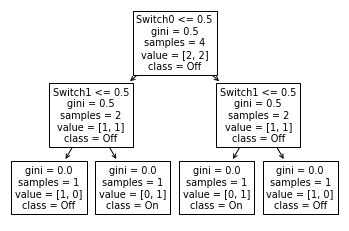

In [43]:
from sklearn.tree import plot_tree
feature_names = ['Switch0', 'Switch1']
class_names = ['Off', 'On']
plot_tree(clf, feature_names=feature_names, class_names=class_names)
plt.show()

Scikit-Learn provides an alternative visualization function. The `export_text` function allows us to display the tree using a simpler, more compact, text-based diagram.

**Listing 22. 46. Displaying a Decision tree classifier as a string**

In [44]:
from sklearn.tree import export_text
text_tree = export_text(clf, feature_names=feature_names)
print(text_tree)

|--- Switch0 <= 0.50
|   |--- Switch1 <= 0.50
|   |   |--- class: 0
|   |--- Switch1 >  0.50
|   |   |--- class: 1
|--- Switch0 >  0.50
|   |--- Switch1 <= 0.50
|   |   |--- class: 1
|   |--- Switch1 >  0.50
|   |   |--- class: 0



Thus far, all of our features have been Booleans. However, in most real-world problems, the features are numeric. Fortunately, any numerical feature can be transformed into a Boolean feature. We simply need to run `feature >= thresh`, where `thresh` is some numeric threshold. In Scikit-Learn, Decision trees scan for this threshold automatically. That is why they split on inequalities.

How should we select the optimal threshold for splitting a numeric feature? Well, we simply choose the threshold that minimizes the Gini Impurity.

**Listing 22. 47. Choosing a threshold by minimizing the Gini Impurity**

Impurity is minimized at a threshold of 0.70


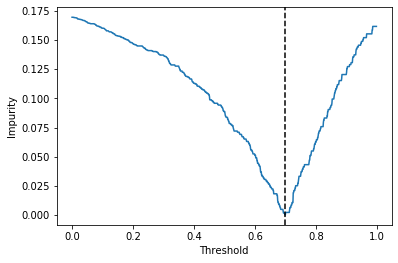

In [45]:
np.random.seed(1)
feature = np.random.normal(size=1000)
y = (feature >= 0.7).astype(int)
thresholds = np.arange(0.0, 1, 0.001) 
gini_impurities = []
for thresh in thresholds:
    y_a = y[feature <= thresh]
    y_b = y[feature >= thresh]
    impurity = compute_impurity(y_a, y_b)
    gini_impurities.append(impurity)

best_thresh = thresholds[np.argmin(gini_impurities)]
print(f"Impurity is minimized at a threshold of {best_thresh:.02f}")
plt.plot(thresholds, gini_impurities)
plt.axvline(best_thresh, c='k', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Impurity')
plt.show()

Scikit-Learn's Decision tree classifier can derive conditional logic from numeric data. Lets now train `clf` on the numeric wine data that we've introduced in the previous section.

**Listing 22. 48. Training a Decision tree on numeric data**

In [46]:
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)
clf.fit(X, y)
feature_names = load_wine().feature_names
text_tree = tree.export_text(clf, feature_names=feature_names)
print(text_tree)

NameError: name 'tree' is not defined

The printed is large because it is **deep**. In machine learning, tree **depth** equals the number of nested if/else statements required to capture the logic within the tree. In Scikit-Learn, we can limit the depth of a trained tree using the `max_depth` hyperparameter.

**Listing 22. 49. Training a tree with limited depth**

In [ ]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X, y)
text_tree = tree.export_text(clf, feature_names=feature_names)
print(text_tree)

The depth at which a feature appears within the tree is an indicator of its relative importance. That depth is determined by the Gini Impurity. Hence, the Gini Impurity can be leveraged to compute an importance score. The importance scores across all features are stored within the `feature_importances_` attribute.

**Listing 22. 50. Printing the feature importances**

In [ ]:
print(clf.feature_importances_)

Most of the features receive a score of `0` because they are not represented in the trained tree. Lets rank the remaining features based on their importance score.

**Listing 22. 51. Ranking relevant features by importance**

In [ ]:
for i in np.argsort(clf.feature_importances_)[::-1]:
    feature = feature_names[i]
    importance = clf.feature_importances_[i]
    if importance == 0:
        break
    
    print(f"'{feature}' has an importance score of {importance:0.2f}")

Tree-based feature ranking can help draw meaningful insights from our data. We'll emphasize this point by exploring the serious problem of cancer diagnosis.

### Studying Cancerous Cells Using Feature Importance

Scikit-Learn includes a cancer-cell dataset. Below, we'll import that data from `sklearn.datasets`.

**Listing 22. 52. Importing Scikit-Learn’s cancer-cell dataset**

In [ ]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
feature_names = data.feature_names
num_features = len(feature_names)
num_classes = len(data.target_names)
print(f"The cancer dataset contains the following {num_classes} classes:")
print(data.target_names)
print(f"\nIt contains these {num_features} features:")
print(feature_names)

The dataset contains 30 different features. Lets rank these features by importance.

**Listing 22. 53. Ranking tumor features by importance**

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
clf = DecisionTreeClassifier()
clf.fit(X, y)
for i in np.argsort(clf.feature_importances_)[::-1]:
    feature = feature_names[i]
    importance = clf.feature_importances_[i]
    if round(importance, 2) == 0:
        break
    print(f"'{feature}' has an importance score of {importance:0.2f}")

Among the top-ranking features, _worst radius_ particularly stands out. Its high score suggests that the radius of the largest cell is an extremely important indicator of cancer. We can check this hypothesis by plotting histograms of the _worst radius_ measurements across the two classes.

**Listing 22. 54. Plotting two _worst radius_ histograms**

In [ ]:
index = clf.feature_importances_.argmax()
plt.hist(X[y == 0][:, index], label='Malignant', bins='auto')
plt.hist(X[y == 1][:, index], label='Benign', color='y', bins='auto',
         alpha=0.5)
plt.xlabel('Worst Radius')
plt.legend()
plt.show()

The histogram reveals an enormous separation between malignant and benign worst-radius measurements. By training a Decision tree, we gained insights into medicine and biology.

## Decision Tree Classifier Limitations

Over-memorization limits the usefulness of our trained models. This is referred to as **overfitting**. Decision tree classifiers are particularly prone to overfitting, since they are able to memorize the training data. For instance, our cancer detector `clf` has perfectly memorized the training set `(X, y)`. We can confirm by outputting the accuracy with which `clf.predict(X)` corresponds to `y`.

**Listing 22. 55. Checking the accuracy of the cancer cell model**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(clf.predict(X), y)
print("Our classifier has memorized the training data with "
      f"{100 * accuracy:.0f}% accuracy.")

The classifier can identify any training example with 100% accuracy. However, this does not mean it can generalize well to real-world data. We can better gage the the classifier's true accuracy using cross-validation.

**Listing 22. 56. Checking model accuracy with cross-validation**

In [ ]:
np.random.seed(0)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, )
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
accuracy = accuracy_score(clf.predict(X_test), y_test)
print(f"The classifier performs with {100 * accuracy:.0f}% accuracy on "
       "the validation set.")

The classifier's true accuracy is at 90%. That accuracy is decent, but we can definitely do better.

## Improving Performance using Random Forest Classification

Sometimes, an the aggregated viewpoint of a crowd outperforms all individual predictions. This aggregated triumph of collective intelligence is called the wisdom of the crowd. Lets explore the wisdom of the crowd by initializing 100 Decision trees. A large collections of trees is referred to as a **forest**. 

**Listing 22. 57. Initializing a 100-tree forest**

In [ ]:
forest = [DecisionTreeClassifier() for _ in range(100)]

How should we train the trees within the forest? Naively, we could train each individual tree on our cancer training set `(X_train, y_train)`. However, we would end up with 100 trees that memorized the exact same data. Instead, we need to randomize our training data, in order to make the trained trees more diverse. We can do this using Bootstrapping with Replacement, as described in Section Seven.

**Listing 22. 58. Randomly sampling a new training set**

In [ ]:
np.random.seed(1)
def bootstrap(X, y): 
    num_rows = X.shape[0]
    indices = np.random.choice(range(num_rows), size=num_rows, 
                               replace=True)
    X_new, y_new = X[indices], y[indices]
    return X_new, y_new
    
X_train_new, y_train_new = bootstrap(X_train, y_train) 
assert X_train.shape == X_train_new.shape
assert y_train.size == y_train_new.size
assert not np.array_equal(X_train, X_train_new)
assert not np.array_equal(y_train, y_train_new)

Now, lets run our `bootstrap` function 100 times in order to generate 100 different training sets.

**Listing 22. 59. Randomly sampling 100 new training sets**

In [ ]:
np.random.seed(1)
features_train, classes_train = [], []
for _ in range(100):
    X_train_new, y_train_new = bootstrap(X_train, y_train)
    features_train.append(X_train_new)
    classes_train.append(y_train_new)

Across our hundred training sets, the data may be different but all the features are the same. However, we can increase the overall diversity by randomizing the features in `features_train`.

**Listing 22. 60. Randomly sampling the training features**

In [ ]:
np.random.seed(1)
sample_size = int(X.shape[1] ** 0.5)
assert sample_size == 5
feature_indices = [np.random.choice(range(30), 5, replace=False)
                   for _ in range(100)]

for i, index_subset in enumerate(feature_indices):
    features_train[i] = features_train[i][:, index_subset]
    
for index in [0, 99]:
    index_subset = feature_indices[index]
    names = feature_names[index_subset]
    print(f"\nRandom features utilized by Tree {index}:")
    print(names)

Lets train each _ith_ tree within `forest` on training set `(features_train[i], classes_train[i])`.

**Listing 22. 61. Training the trees within the forest**

In [ ]:
for i, clf_tree in enumerate(forest):
    clf_tree.fit(features_train[i], classes_train[i])

We've trained every tree within the forest. Now, lets put the trained trees to a vote. What is the class-label of the data-point at `X_test[0]`? We can check using the wisdom of the crowd.

**Listing 22. 62. Using tree-voting to classify a data-point**

In [ ]:
from collections import Counter
feature_vector = X_test[0]
votes = []
for i, clf_tree in enumerate(forest):
    index_subset = feature_indices[i]
    vector_subset = feature_vector[index_subset]
    prediction = clf_tree.predict([vector_subset])[0] 
    votes.append(prediction)

class_to_votes = Counter(votes)
for class_label, votes in class_to_votes.items():
    print(f"We counted {votes} votes for class {class_label}.")
    
top_class = max(class_to_votes.items(), key=lambda x: x[1])[0]
print(f"\nClass {top_class} has received the plurality of the votes.")

93% of the trees have voted for Class 0. Lets check if this majority vote is correct.

**Listing 22. 63. Checking the true class of the predicted label**

In [ ]:
true_label = y_test[0]
print(f"The true class of the data-point is {true_label}.")

The forest has identified the point at `X_test[0]`. Now, we will use voting to identify all points in the validation set. Afterwards, we'll measure our prediction accuracy.

**Listing 22. 64. Measuring the accuracy of the forest model**

In [ ]:
predictions = []
for i, clf_tree in enumerate(forest):
    index_subset = feature_indices[i]
    prediction = clf_tree.predict(X_test[:,index_subset])
    predictions.append(prediction)

predictions = np.array(predictions)
y_pred = [Counter(predictions[:,i]).most_common()[0][0]
          for i in range(y_test.size)]
accuracy = accuracy_score(y_pred, y_test)
print("The forest has predicted the validation outputs with "
      f"{100 * accuracy:.0f}% accuracy")

y leveraging the wisdom of the crowd, we have managed to improve performance. In the process, we have also trained a **Random Forest classifier**. Random Forest classifiers are collections of trees whose training inputs are randomized to maximize diversity.

## Training Random Forest Classifiers Using Scikit-Learn
In Scikit-Learn, Random Forest classification is carried out by the `RandomForestClassifier` class. 

**Listing 22. 65. Training a Random Forest classifier**

In [ ]:
np.random.seed(1)
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier()
clf_forest.fit(X_train, y_train)
y_pred = clf_forest.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print("The forest has predicted the validation outputs with "
      f"{100 * accuracy:.0f}% accuracy")

By default, Scikit-Learn's Random Forest classifier utilizes 100 decision trees. However, we can specify a lower or higher count using the `n_estimators` parameter. Below, we'll lower the number of trees to 10.

**Listing 22. 66. Training a 10-tree Random Forest classifier**

In [ ]:
np.random.seed(1)
clf_forest = RandomForestClassifier(n_estimators=10)
clf_forest.fit(X_train, y_train)
y_pred = clf_forest.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print("The 10-tree forest has predicted the validation outputs with "
      f"{100 * accuracy:.0f}% accuracy")

Each of the 10 trees is assigned a random subset of five features. Every feature in the subset contains its own feature importance score. Scikit-Learn is able to average all these scores across all the trees. The aggregated averages can be accessed by calling `clf_forest.feature_importances_`. 

**Listing 22. 67. Ranking the Random Forest features**

In [ ]:
for i in np.argsort(clf_forest.feature_importances_)[::-1][:3]:
    feature = feature_names[i]
    importance = clf_forest.feature_importances_[i]
    print(f"'{feature}' has an importance score of {importance:0.2f}")